In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Initialize RNN

In [2]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100

In [3]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(
    N_inp, N_bar, num_states,
    #plasticity_bias = -0.45,
    narrow_search_factor=0.5, wide_search_factor=1.5,
    )
unskewed_J = model.J_xx.copy()

In [66]:
cache_states = [50]

# Learning without skew

In [71]:
identification_s = 0.

Now I just cached at location: 50


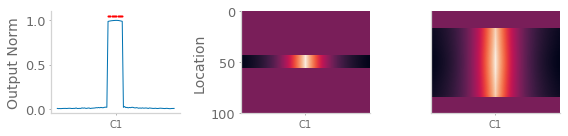

In [72]:
model.reset()
model.J_xx = unskewed_J.copy()
    
cache_identification = []
narrow_recall = []
wide_recall = []

for c_idx, cache_state in enumerate(cache_states):
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

    _, _, _cache_identification, _ = model.run_recall(identification_s, place_inputs)
    cache_identification.append(_cache_identification.copy())
    
    _, _, _narrow_recall, _ = model.run_recall(identification_s, place_inputs)
    narrow_recall.append(_narrow_recall.copy())
    
    _, _, _wide_recall, _ = model.run_wide_recall(place_inputs)
    wide_recall.append(_wide_recall.copy())

    recall_plots(_cache_identification, _narrow_recall, _wide_recall, cache_states[:c_idx+1])

# Add predictive skew to RNN weights

In [87]:
model.reset()
model.J_xx = unskewed_J.copy()

In [ ]:
identity = np.eye(model.N_bar)
total_delta = np.zeros((model.N_bar, model.N_bar))
n_shifts = 1000
offset = 50
gamma = 0.98
for s in range(1, n_shifts):
    shifted = np.roll(identity, shift=-(s+offset), axis=0)
    delta = (gamma**s)*shifted*0.1 #0.04
    total_delta += delta.copy()
model.J_xx[:,int(0.2*5000):int(0.2*5000)] += total_delta[:, int(0.3*5000):int(0.5*5000)]

# Learning with skew

In [ ]:
cache_identification = []
narrow_recall = []
wide_recall = []

for c_idx, cache_state in enumerate(cache_states):
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

    _, _, _cache_identification, _ = model.run_recall(identification_s, place_inputs)
    cache_identification.append(_cache_identification.copy())
    
    _, _, _narrow_recall, _ = model.run_recall(identification_s, place_inputs)
    narrow_recall.append(_narrow_recall.copy())
    
    _, _, _wide_recall, _ = model.run_wide_recall(place_inputs)
    wide_recall.append(_wide_recall.copy())

    recall_plots(_cache_identification, _narrow_recall, _wide_recall, cache_states[:c_idx+1])